In [177]:
%load_ext rmagic 

/Users/grgliner/anaconda/lib/python2.7/site-packages/IPython/extensions/rmagic.py:11: UserWarning: The rmagic extension in IPython has moved to `rpy2.ipython`, please see `rpy2` documentation.
  warnings.warn("The rmagic extension in IPython has moved to "


# Imports

In [2]:
#import pymc as pm
import pymc3 as pm
import pymc.graph
import pandas as pd
#import pydot
import numpy as np
from pylab import pcolor, show, colorbar, xticks
import matplotlib.pyplot as plt
import IPython.display
import gzip
%matplotlib inline

In [86]:
X = np.array([1,1,1,0])
Y = np.array([1,1,0,1])

# Import/Simulate the predictor data and define constants
Currently eveything is simulated.  Very soon I will be using actual haplotypes from GTEx and simulating readcounts from there.  Need to talk to Derek or Greg about creating the positive definite relatedness matrix.

Making the relateness matrix
(212, 2063)
True
True


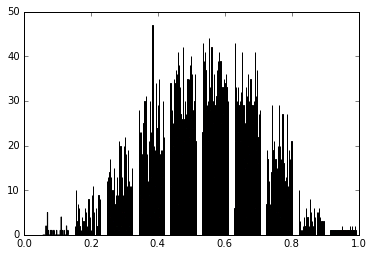

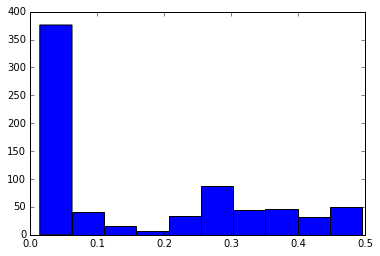

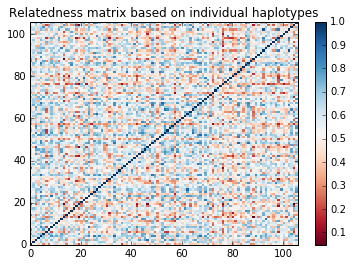

In [69]:
#Function defining the correlation of between two haplotypes based on Ancestral haplotype-based association mapping with generalized linear mixed models accounting for stratification
#Inputes are haplotype 1 and haplotype 2 for each individual for i in range(0,rfdata.nsamples):
#  for j in range(i,rfdata.nsamples):
#      relate[i,j] = haplotypeKernel(hap1[i],hap2[i],hap1[j],hap2[j])
def haplotypeKernel(x1,x2,y1,y2):
    I11 = x1 == y1
    I12 = x1==y2
    I21 = x2==y1
    I22 = x2==y2
    Sxy = .25*(I11*1 + I12*1 + I21*1 + I22*1)
    #Then to get the relatednss between individual x and y, 
    #I need to average this across all snps and perform normalizing 
    #by subtracting the minimum for that individual and dividing by
    #1 - min
    #(np.mean(Sxy) - np.min(Sxy))/(1 - np.min(Sxy))
    return np.mean(Sxy)


def haplotypeSimKernel(x,y):
    Sxy = np.mean(x == y)
    #Then to get the relatednss between individual x and y, 
    #I need to average this across all snps and perform normalizing 
    #by subtracting the minimum for that individual and dividing by
    #normalize
    return 2*Sxy - 1

def getMAF(x):
    maf = np.mean(x)/2
    if (maf > .5):
        maf = 1 - maf
    return maf

class rasqualData:
    def __init__(self):
        self.filename = []
        self.nsamples = 0
        self.geno = []
        self.hap1 = []
        self.hap2 = []
        self.refreads = []
        self.altreads = []
        self.nhet = 0
        self.nhomref = 0
        self.nhomalt = 0
        self.snps = []
        self.snppos = []
        self.samples = []
        self.group = [] #for clustered modeling
        self.error = False
        self.maf = []
        
    def addvalues(self, ff):
        self.filename = ff
        if ff[-3:] == '.gz':
            f = gzip.open(ff)
            data = f.readlines()
            f.close()
        else:
            with open(ff) as f:
                data = f.readlines()
        for line in data:
            if line[0] != '#' and len(line.split('\t')) > 2:
                #get the snp
                self.snps.append(line.split('\t')[2])
                self.snppos.append(line.split('\t')[1])
                ## Add a try/catch statement to throw false so I can add this file to a failed list
                #get the genotypes
                data = [e.replace(':','|').split('|') for e in line.split('\t')[9:]]
                self.geno.append([int(e[0]) + int(e[1]) for e in data])
                self.maf.append(getMAF(np.array([float(e[0]) + float(e[1]) for e in data])))
                self.hap1.append([int(e[0]) for e in data])
                self.hap2.append([int(e[1]) for e in data])
            elif line[0:6] == '#CHROM':
                #get the sample headers
                self.samples = line.split('\t')[9:]
                self.nsamples = len(self.samples)
                self.group = np.array(range(self.nsamples) + range(self.nsamples)) +1
            
            
rfdata = rasqualData()
rfdata2 = rasqualData()
rfdata3 = rasqualData()
rfdata.addvalues('/Users/grgliner/Dropbox/Barbara/LocalAnalysis/gtexdata/gtex_chr1_RPA2_tx_maf01.recode.vcf.new.gz')
rfdata2.addvalues('/Users/grgliner/Dropbox/Barbara/LocalAnalysis/gtexdata/gtex_chr15_FAM154B_tx_maf01.recode.vcf.new.gz')
rfdata3.addvalues('/Users/grgliner/Dropbox/Barbara/LocalAnalysis/gtexdata/gtex_chr16_LA16c-325D7.2_tx_maf01.recode.vcf.new.gz')
print "Making the relateness matrix"
relate = np.zeros((rfdata.nsamples,rfdata.nsamples))
relatehap1 = np.zeros(())
hap1 = np.array(rfdata.hap1).T
hap2 = np.array(rfdata.hap2).T
haps = np.vstack((hap1,hap2))
hap1 = np.array(rfdata2.hap1).T
hap2 = np.array(rfdata2.hap2).T
haps = np.hstack((haps,np.vstack((hap1,hap2))))
hap1 = np.array(rfdata3.hap1).T
hap2 = np.array(rfdata3.hap2).T
haps = np.hstack((haps,np.vstack((hap1,hap2))))
print haps.shape
KK = np.zeros((haps.shape[0],haps.shape[0]))

for i in range(0,haps.shape[0]):
    KK[i, :] = [haplotypeSimKernel(haps[i],k) for k in haps]

#Check eigenvalues
print np.all(np.linalg.eigvals(KK) > 0)
n_count_data = rfdata.nsamples*2 #2n individuals


geno = np.vstack((rfdata2.geno, rfdata3.geno))
kgeno = np.abs(np.corrcoef(np.matrix(geno).T))#.T*np.matrix(rfdata.geno)
print np.all(np.linalg.eigvals(kgeno) > 0)

plt.hist(kgeno)
plt.show()

plt.hist(rfdata.maf)
plt.show()

# plotting the correlation matrix
plt.pcolor(kgeno,cmap='RdBu')
colorbar()
plt.axis('tight')
plt.title('Relatedness matrix based on individual haplotypes')
#yticks(arange(0.5,10.5),range(0,10))
#xticks(arange(0.5,10.5),range(0,10))
show()


U, s, V = np.linalg.svd(kgeno, full_matrices=True)
G = U*np.diag(np.sqrt(s))
GG = np.hstack((np.vstack((G,G)), np.zeros((G.shape[0]*2, G.shape[1]))))

In [134]:
print beta
#Start compiling functions
trace.get_values('name').mean()
forestplot(trace_obj, vars=None, alpha=0.05, quartiles=True, rhat=True,
               main=None, xtitle=None, xrange=None, ylabels=None,
               chain_spacing=0.05, vline=0, gs=None):
    """ Forest plot (model summary plot)
    Generates a "forest plot" of 100*(1-alpha)% credible intervals for either
    the set of variables in a given model, or a specified set of nodes.
    :Arguments:
        trace_obj: NpTrace or MultiTrace object
            Trace(s) from an MCMC sample.
        vars: list
            List of variables to plot (defaults to None, which results in all
            variables plotted).
        alpha (optional): float
            Alpha value for (1-alpha)*100% credible intervals (defaults to
            0.05).
        quartiles (optional): bool
            Flag for plotting the interquartile range, in addition to the
            (1-alpha)*100% intervals (defaults to True).
        rhat (optional): bool
            Flag for plotting Gelman-Rubin statistics. Requires 2 or more
            chains (defaults to True).
        main (optional): string
            Title for main plot. Passing False results in titles being
            suppressed; passing None (default) results in default titles.
        xtitle (optional): string
            Label for x-axis. Defaults to no label
        xrange (optional): list or tuple
            Range for x-axis. Defaults to matplotlib's best guess.
        ylabels (optional): list or array
            User-defined labels for each variable. If not provided, the node
            __name__ attributes are used.
        chain_spacing (optional): float
            Plot spacing between chains (defaults to 0.05).
        vline (optional): numeric
            Location of vertical reference line (defaults to 0).
            
        gs : GridSpec
            Matplotlib GridSpec object. Defaults to None.
            
        Returns
        -------

pm.glm.plot_posterior_predictive(trace, samples=100,
                                 label='posterior predictive regression lines',
                                 c='blue', alpha=0.2)
plt.plot(x, _a*x + _b, label='true regression line', lw=3., c='red')
plt.legend(loc='best');
df_trace = pm.trace_to_dataframe(trace)
pd.scatter_matrix(df_trace[-1000:], diagonal='kde');
autocorrplot(trace, vars=None, max_lag=100, burn=0, ax=None,
                 symmetric_plot=False):
    """Bar plot of the autocorrelation function for a trace
    Parameters
    ----------
    trace : result of MCMC run
    vars : list of variable names
        Variables to be plotted, if None all variable are plotted.
        Vector-value stochastics are handled automatically.
    max_lag : int
        Maximum lag to calculate autocorrelation. Defaults to 100.
    burn : int
        Number of samples to discard from the beginning of the trace. 
        Defaults to 0.
    ax : axes
        Matplotlib axes. Defaults to None.
    symmetric_plot : boolean
        Plot from either [0, +lag] or [-lag, lag]. Defaults to False, [-, +lag].
        
    Returns
    -------
    ax : matplotlib axes
    """
var_str(name, shape):
    """Return a sequence of strings naming the element of the tallyable object.
    This is a support function for forestplot.
    :Example:
    >>> var_str('theta', (4,))
    ['theta[1]', 'theta[2]', 'theta[3]', 'theta[4]']
 Metropolis(ArrayStepShared):
    """
    Metropolis-Hastings sampling step
    Parameters
    ----------
    vars : list
        List of variables for sampler
    S : standard deviation or covariance matrix
        Some measure of variance to parameterize proposal distribution
    proposal_dist : function
        Function that returns zero-mean deviates when parameterized with
        S (and n). Defaults to quad_potential.
    scaling : scalar or array
        Initial scale factor for proposal. Defaults to 1.
    tune : bool
        Flag for tuning. Defaults to True.
    model : PyMC Model
        Optional model for sampling step. Defaults to None (taken from context).
    """

effect_size


In [180]:
help(pm.MultiModelInference)

AttributeError: 'module' object has no attribute 'MultiModelInference'

## Running simulation on several effect sizes and minor allele frequencies
For this function I assume that the relatedness matrix has already been computed

Populating the interactive namespace from numpy and matplotlib
5_1.22140275816
 [-----------------100%-----------------] 50000 of 50000 complete in 27.8 sec152_1.22140275816
 [-----------------100%-----------------] 50000 of 50000 complete in 23.8 sec209_1.22140275816
 [-----------------100%-----------------] 50000 of 50000 complete in 22.5 sec106_1.22140275816
 [-----------------100%-----------------] 50000 of 50000 complete in 22.3 sec62_1.22140275816
 [-----------------100%-----------------] 50000 of 50000 complete in 24.4 sec

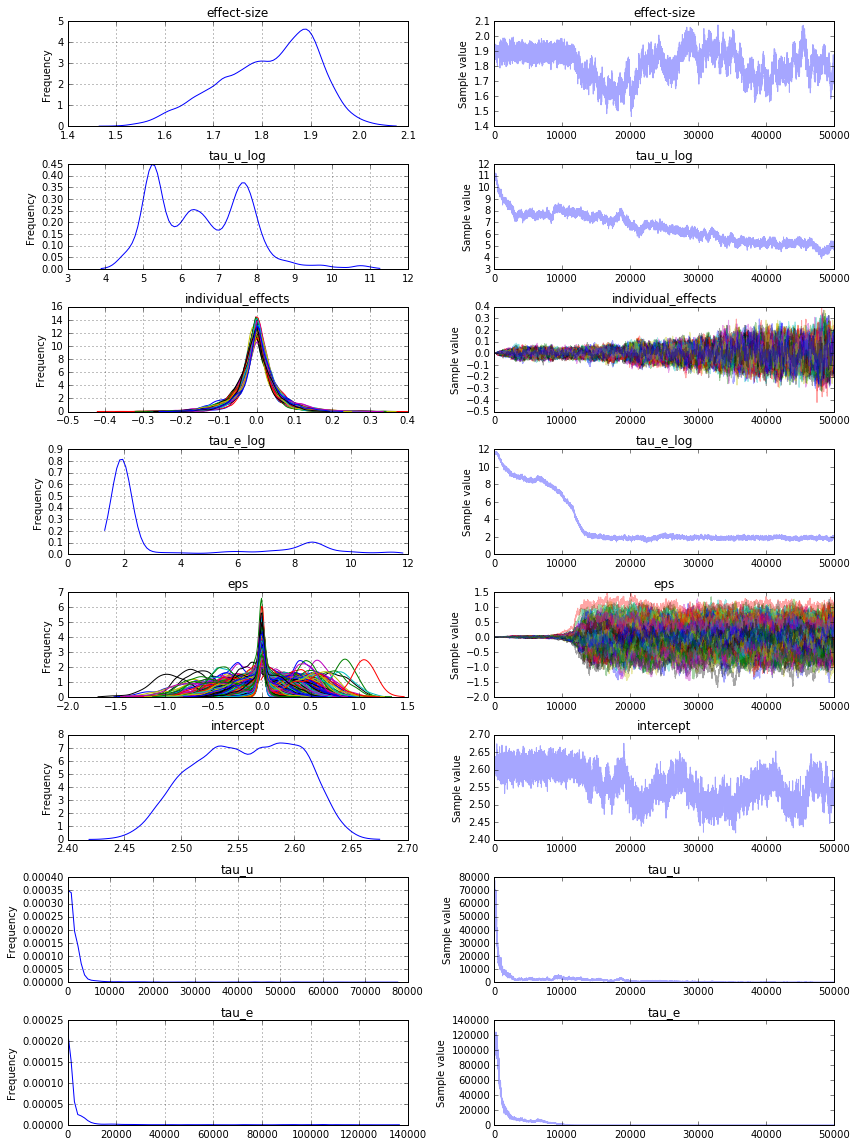

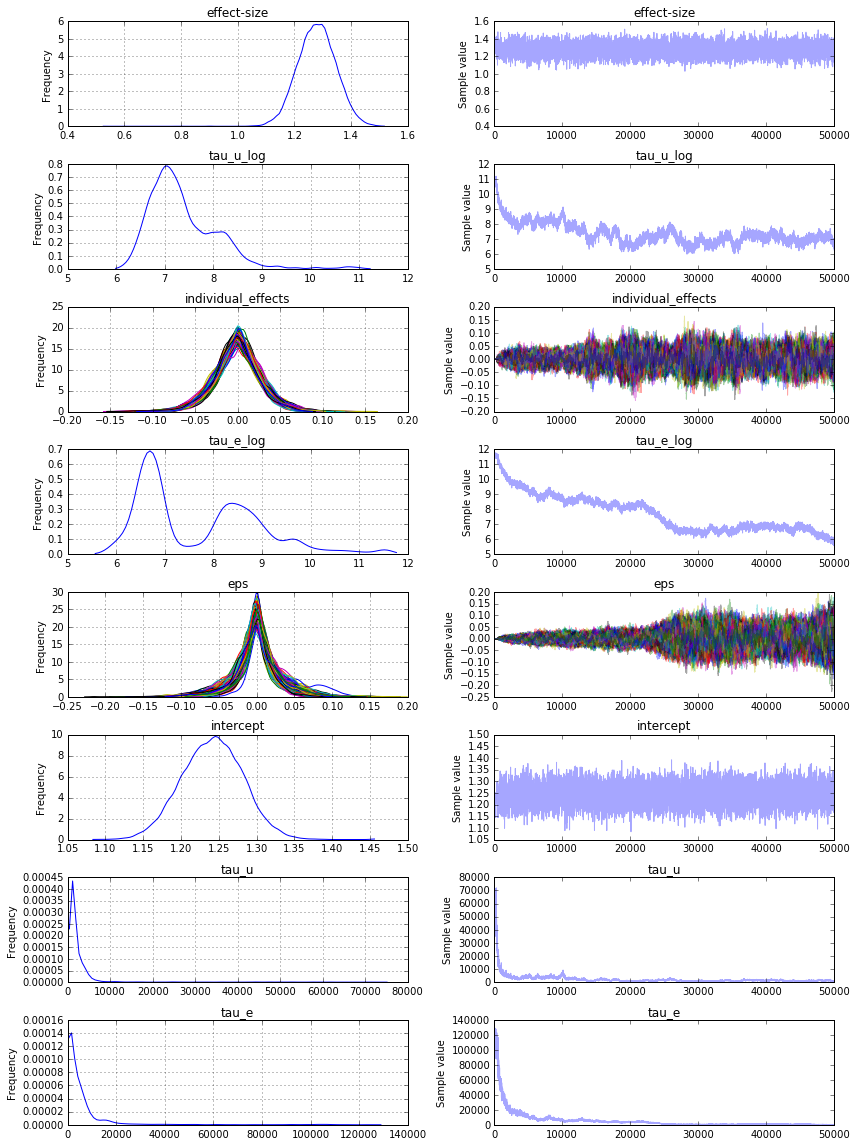

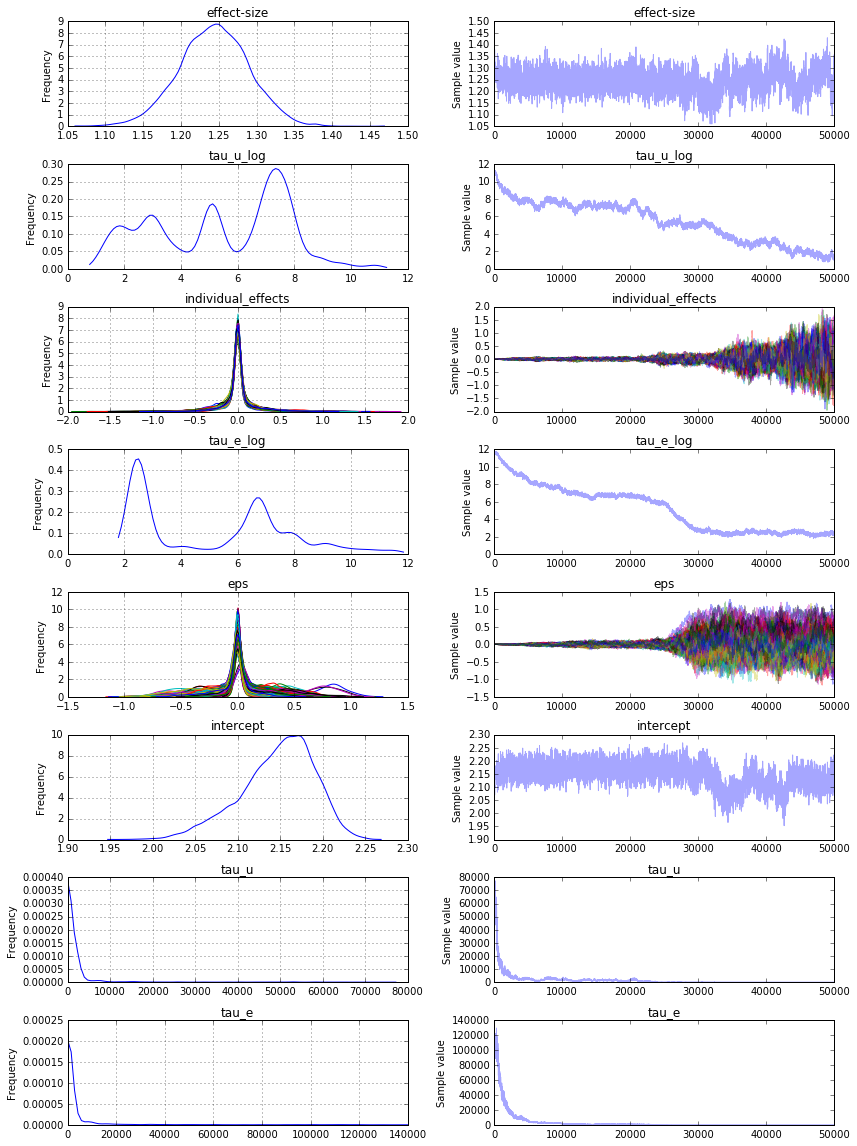

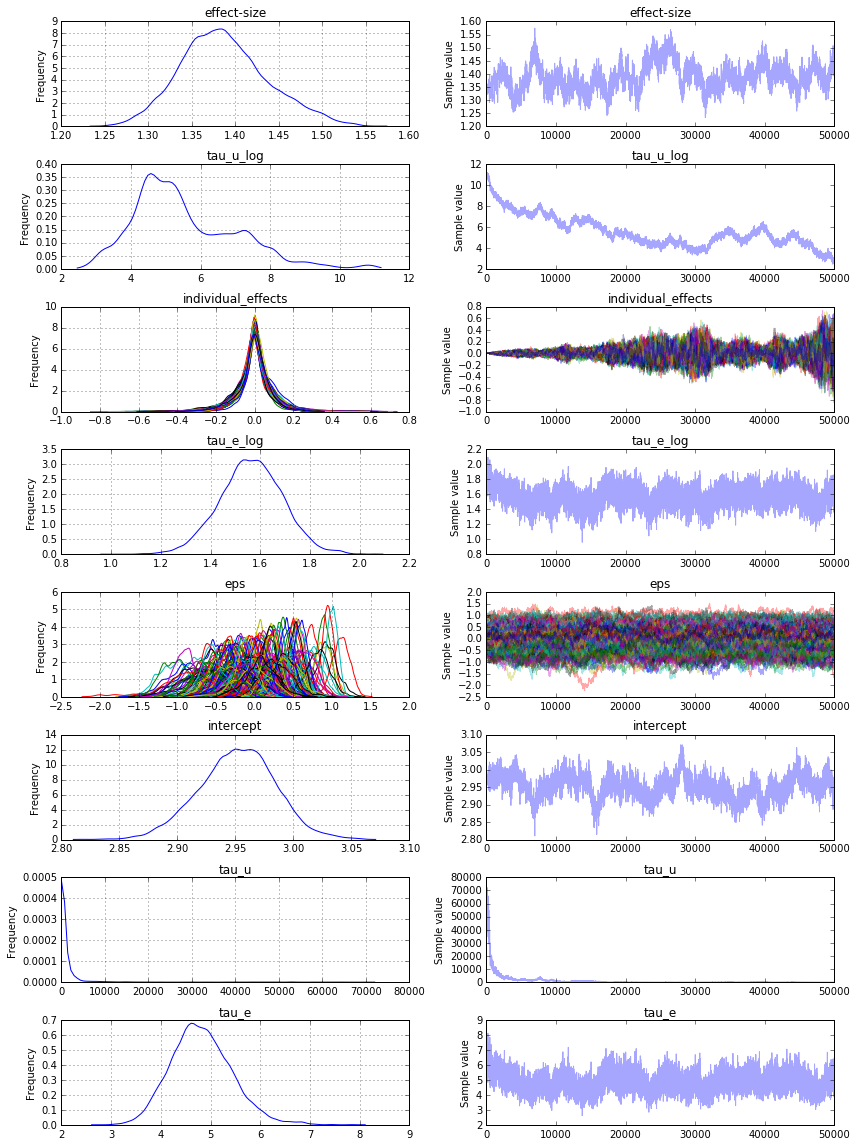

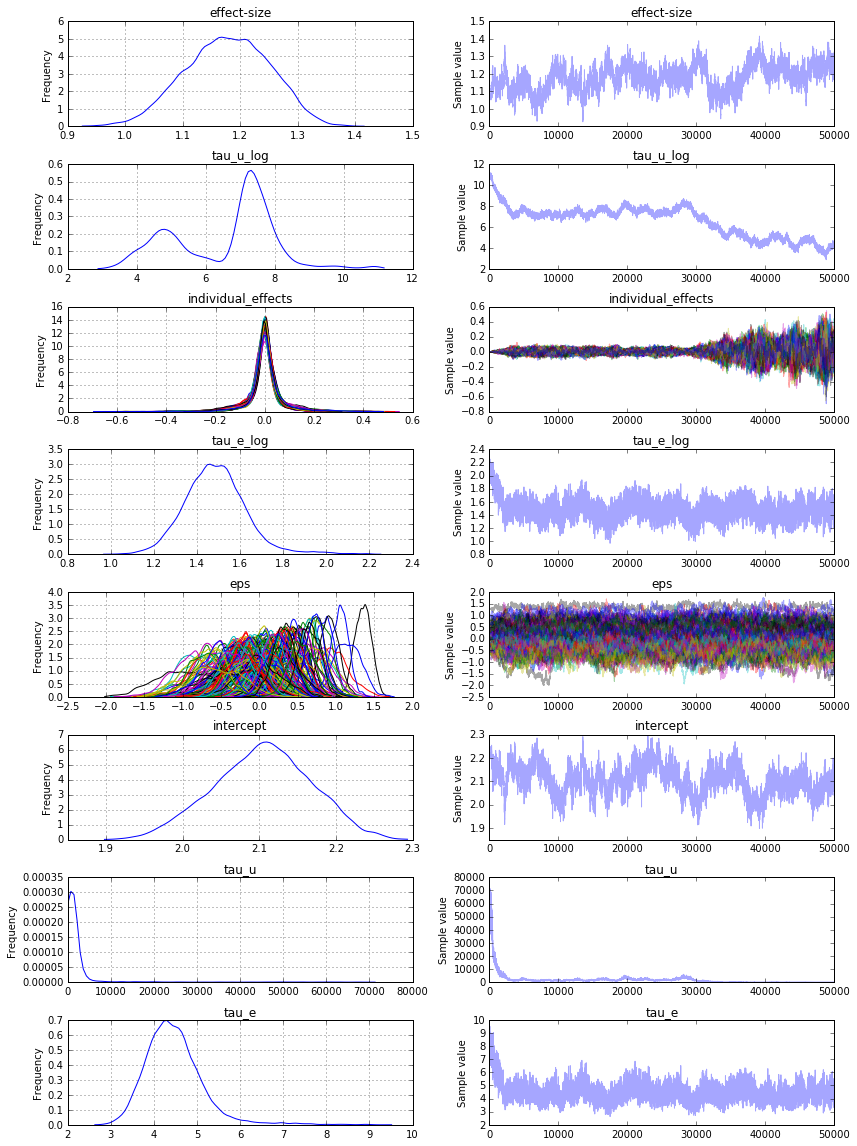

In [189]:
%pylab --no-import-all inline
import pymc3 as pm
import scipy as sp
import theano.tensor as tt
from numpy import random, sum as nsum, ones, concatenate, newaxis, dot, arange
import numpy as np

def BayesFactor(y, x, group, G, regression="normal", error="uniform", itr=50000, prior_model_prob = 0.5):
    with pm.Model() as model:
        # Index to true model
        tau = pm.Bernoulli('tau', prior_model_prob)
    
        # Effect Size Priors: I can add hyperparameters in the futuer for the scale
        #
        if regression == "cauchy":
            beta = pm.Cauchy('effect-size', alpha=0, beta=1)  
        elif regression == "normal":
            beta = pm.Normal('effect-size', mu=0, tau=1.0) 
        elif regression == "laplace":
            beta = pm.Laplace('effect-size', mu=0, b=1.0) 
        elif regression == "flat":
            beta = pm.Uniform('effect-size', lower=0, upper=3) 
        else:
            raise ValueError, "No regression of type {}".format(regression)       
        
        # Random Effect Priors
        #
        #Test different hyperparameters
        if error == "gamma":
            tau_u = pm.Gamma("tau_u", 1.e-3, 1.e-3) #use 1, .01, .001
            group_effects = pm.Normal("individual_effects", 0, tau=tau_u, shape=n_groups)
        elif error == "flat":
            tau_u = pm.Flat('tau_u', 1, testval=1.0)
            group_effects = pm.Normal("individual_effects", 0, sd=tau_u, shape=n_groups)
        elif error == "uniform":
            tau_u = pm.Uniform('tau_u', lower=0, upper=100)
            group_effects = pm.Normal("individual_effects", 0, sd=tau_u, shape=n_groups)
        elif error == "halfcauchy":
            tau_u = pm.HalfCauchy('tau_u', 1, testval=1.0)
            group_effects = pm.Normal("individual_effects", 0, tau=tau_u, shape=n_groups)
        else:
            raise ValueError, "No error of type {}".format(regression)
        
        #Define the random effects
        random = tt.dot(G,group_effects)
   
        # Error Priors
        #
        if error == "gamma":
            tau_e = pm.Gamma("tau_e", 1.e-3, 1.e-3) #use 1, .01, .001
            eps = pm.Normal('eps', mu=0, tau=tau_e,shape=n_observed)
        elif error == "flat":
            tau_e = pm.Flat('tau_e')
            eps = pm.Normal('eps', mu=0, sd=tau_e,shape=n_observed)
        elif error == "uniform":
            tau_e = pm.Uniform('tau_e', lower=0, upper=100)
            eps = pm.Normal('eps', mu=0, sd=tau_e,shape=n_observed)
        elif error == "halfcauchy":
            tau_e = pm.HalfCauchy('tau_e', 1, testval=1.0)
            eps = pm.Normal('eps', mu=0, tau=tau_e,shape=n_observed)
        else:
            raise ValueError, "No error of type {}".format(regression)

        # Intercept
        # 
        intercept = pm.Flat('intercept')
 
        #Define Model
        #
        g = tt.constant(group)
        mu1 = tt.exp(intercept + eps + random[g] + beta*x )
        y1_est = pm.Poisson('y_est', mu=mu1)
        
        mu2 = tt.exp(intercept + eps + random[g])
        y2_est = pm.Poisson('y2_est', mu=mu2)
        
        y_like = pm.DensityDist('y_like', lambda value: pm.switch(tau, y1_est.logp(value), y2_est.logp(value)), observed=y)
        
        start = find_MAP()
        step1 = pm.Metropolis([eps, beta, group_effects, tau_e, tau_u])
        step2 = pm.ElemwiseCategoricalStep(var=tau, values=[0,1])
        trace = pm.sample(itr, step=[step1, step2], start=start)
        _ = pm.traceplot(trace[burnin:], vars=['tau'])
        
        prob_pois = trace[burnin:]['tau'].mean()
        prob_nb = 1 - prob_pois
        BF = (prob_nb/prob_pois)*(prior_model_prob/(1-prior_model_prob))
        print("Bayes Factor: %s" % BF)

    return BF

#Define the pymc3 model
def regress( y, x, group, G, regression="normal", random="halfcauchy", error="gamma", itr=50000):
    with pm.Model() as model:
        
        # Effect Size Priors: I can add hyperparameters in the futuer for the scale
        #
        if regression == "cauchy":
            beta = pm.Cauchy('effect-size', alpha=0, beta=1)  
        elif regression == "normal":
            beta = pm.Normal('effect-size', mu=0, tau=1.0) 
        elif regression == "laplace":
            beta = pm.Laplace('effect-size', mu=0, b=1.0) 
        elif regression == "flat":
            beta = pm.Uniform('effect-size', lower=0, upper=3) 
        else:
            raise ValueError, "No regression of type {}".format(regression)       
        
        # Random Effect Priors
        #
        #Test different hyperparameters
        if random == "gamma":
            tau_u = pm.Gamma("tau_u", 1.e-3, 1.e-3) #use 1, .01, .001
            group_effects = pm.Normal("individual_effects", 0, tau=tau_u, shape=n_groups)
        elif random == "flat":
            tau_u = pm.Flat('tau_u', 1, testval=1.0)
            group_effects = pm.Normal("individual_effects", 0, sd=tau_u, shape=n_groups)
        elif random == "uniform":
            tau_u = pm.Uniform('tau_u', lower=0, upper=20)
            group_effects = pm.Normal("individual_effects", 0, sd=tau_u, shape=n_groups)
        elif random == "halfcauchy":
            tau_u = pm.HalfCauchy('tau_u', 1, testval=1)
            group_effects = pm.Normal("individual_effects", 0, tau=tau_u, shape=n_groups)
        else:
            raise ValueError, "No error of type {}".format(regression)
        
        #Define the random effects
        random = tt.dot(G,group_effects)
   
        # Error Priors
        #
        if error == "gamma":
            tau_e = pm.Gamma("tau_e", 1.e-3, 1.e-3) #use 1, .01, .001
            eps = pm.Normal('eps', mu=0, tau=tau_e,shape=n_observed)
        elif error == "flat":
            tau_e = pm.Flat('tau_e')
            eps = pm.Normal('eps', mu=0, sd=tau_e,shape=n_observed)
        elif error == "uniform":
            tau_e = pm.Uniform('tau_e', lower=0, upper=1)
            eps = pm.Normal('eps', mu=0, sd=tau_e,shape=n_observed)
        elif error == "halfcauchy":
            tau_e = pm.HalfCauchy('tau_e', 1, testval=1.0)
            eps = pm.Normal('eps', mu=0, tau=tau_e,shape=n_observed)
        else:
            raise ValueError, "No error of type {}".format(regression)

        # Intercept
        # 
        intercept = pm.Flat('intercept')
 
        #Define Model
        #
        g = tt.constant(group)
        mu = tt.exp(intercept + eps + random[g] + beta*x )
        y_est = pm.Poisson('y_est', mu=mu, observed=y)

        start = find_MAP(fmin=sp.optimize.fmin_powell)
        #for k in start:
        #    if (start[k] == np.array(0.0)).all() or True: start[k] += .01 # avoids some corner cases?
        #print("starting trace at MAP:", start)
        #h = find_hessian(start)

        step = Metropolis()
        #step =  pm.CompoundStep([pm.Metropolis([total_lambda_mu]),
        #                 pm.Metropolis([total_lambda_tau]),
        #                 pm.Metropolis([total_lambda]),
        #                 pm.Metropolis([loss_lambda_factor]),
        #                 ]) 
        #step = Slice()
        #step = NUTS()
        trace = pm.sample(itr, step, start, progressbar=True,njobs=1)
        pm.traceplot(trace)
    return trace

#########################################################################################################
#
# Start Script
#
#########################################################################################################

#Select the SNP pos for each minor allele frequency 
n_count_data = rfdata.nsamples*2
mafofinterest = [.05, .1, .2, .3, .4]
causalidx = []
for m in mafofinterest:
    causalidx.append(next(x[0] for x in enumerate(rfdata.maf) if x[1] >= m and x[1] < m +.1))

#Simulate readcounts for each effect size
effect_sizes = [.2, .3, .4, .5, .6, .7]
actual_ES = np.exp(effect_sizes)

#We assume that the interceot, random effects and noise are generated by the same parameters throughout.  Set these parameters.
sigma_u_actual = .5 #1, .01 sigma^2
sigma_e_actual = .01
beta_0_actual = np.log(10)
    
#Simulate readcounts at each causal SNP for each effect size 
Y_dict = {}
Ntrace = {}
G = np.array(G)
for m in causalidx:
    Y = [] #initialize readcount matrix where each column represents a maf
    x = np.array(rfdata.hap1[m] + rfdata.hap2[m])
    for b in actual_ES[0:1]:
        Y.append(simulateRespons(x, beta_0_actual, b, sigma_u_actual, sigma_e_actual, kgeno, n_count_data, False))
        print str(m) + '_' + str(b)
        trace = regress(Y[-1], x, group, G, regression="normal", random="gamma", error="gamma", itr=50000)
        #BF = BayesFactor(Y[-1], x, group, G, regression="normal", error="uniform")
    Y_dict[m] = Y

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x4151f0250>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1f990d290>]], dtype=object)

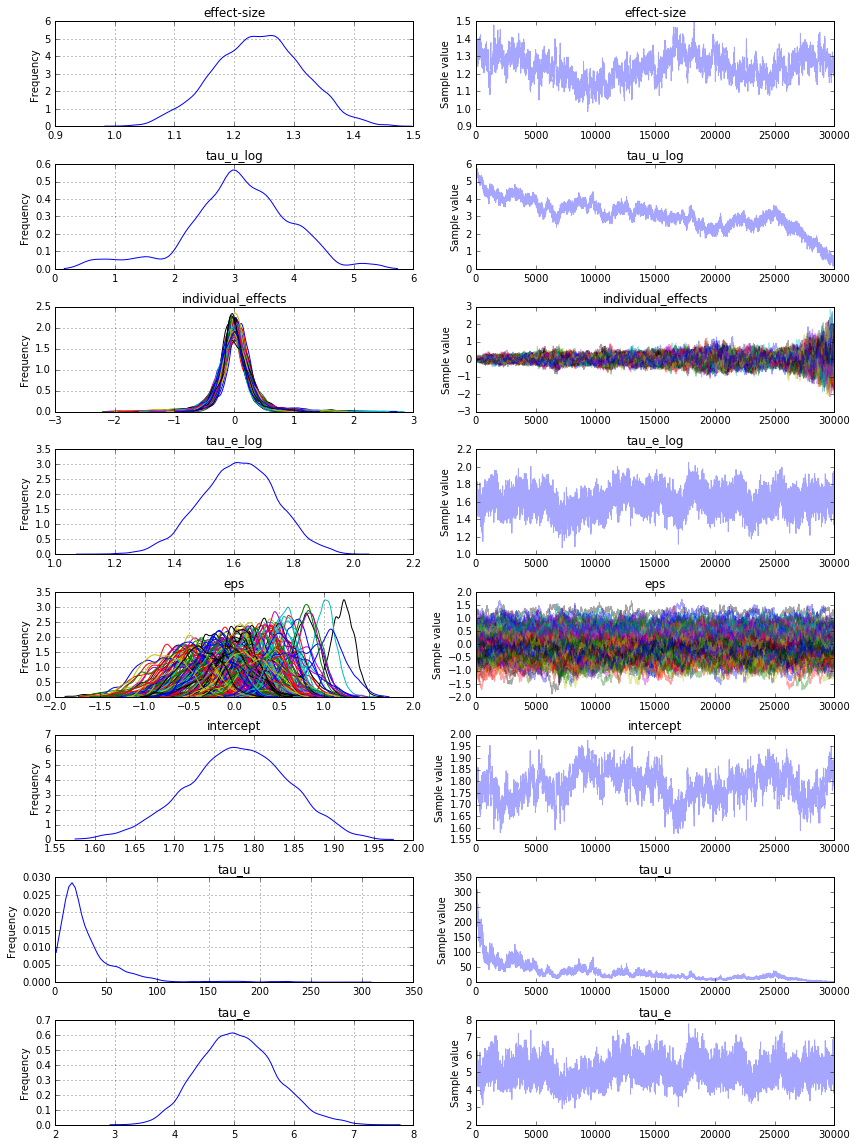

In [183]:
pm.traceplot(trace[20000:])

In [41]:
def runsim(dir,geneName,testName,effectSize,variance,causalMafCutoff,sigMafCutoff,numSimRounds,rfdata):
    print "EFFECT SIZE: " effectSize
    beta_actual = np.log(effectSize)
    sigma_u_actual = 1.5 #1
    sigma_e_actual = .01
    beta_0_actual = np.log(10)
    
    #Trim snps according to the maf threshold
    maflist = rfdata.maf
    keepidx = maf > sigMafCutoff
    keepmaf = maflist[keepidx]
    snps = rfdata.snps[keepidx]
    snppos = rfdata.snppost[keepidx]
    hap1 = rfdata.hap1[keepidx,:]
    hap2 = rfdata.hap2[keepidx,:]
    numSnps = len(snps)
    n_count_data = rfdata.nsamples*2
    
    
    # pick causal SNP according to MAF threhsold
    causalIdx = np.random(range(len(numSnps)))
    maf = keepmaf[causalIdx]

    while(maf < causalMafCutoff):
        causalIdx = np.random(range(len(numSnps))))
        maf = keepmaf[causalIdx]
    
    causalPos = snppos[causalIdx]
    causalpredictor = np.array(hap1[causalIdx] + hap2[causalIdx])
    pheno = []
    
    for k in range(numSimRounds):
        y = simulateRespons(causalpredictor, beta_0_actual, beta_actual, sigma_u_actual, sigma_e_actual, kgeno, n_count_data, True)

        pheno <- rnorm(dim(snps)[2],causalSnp*effectSize,variance)
        # All test stats are assessed for significance by MAX
        statistics <- data.frame()
        classification <- c(rep(0,dim(snps)[1]-1),1)
        #statistics$classification <- classification
        statistics <- data.frame(classification)

        for(test in testName){
        #statisticValues <- apply(snps,1,match.fun(testName),pheno) # apply to each SNP
            statisticValues <- apply(snps,1,match.fun(test),pheno) # apply to each SNP
            statisticValues <- statisticValues/max(statisticValues)
            statistics <- cbind(statistics,statisticValues)
        }
            colnames(statistics) <- c("classification",testName)
            df <- rbind(df,statistics)
            pdf("invest.pdf",width=8,height=8)

            #statSort <- data.frame(cbind(statisticValues,c(1:length(statisticValues))))
            #statSort <- statSort[order(-statisticValues),]

            statSort <- data.frame(cbind(statistics$regression,c(1:length(statistics$regression))))
            statSort <- statSort[order(-statistics$regression),]

            snpMat <- c()
            for(i in 1:length(statSort$X2)){
                snpMat <- rbind(snpMat,snps[statSort$X2[i],])
            }

            for(i in 1:dim(snpMat)[1]){
                if(i %% 10 == 0){print(i)}
                snp = snpMat[i,]
                ld <- abs(cor(snp,causalSnp))
                maf <- mean(snp)/2
                X <- cbind(1, snp)
                betaHat <- solve(t(X) %*% X) %*% t(X) %*% pheno
                beta <- betaHat[2]
                var_betaHat <- anova(lm(pheno~snp))[[3]][2] * solve(t(X) %*% X)
                var_betaHat <- format(round(sqrt(diag(var_betaHat)[2]),4),nsmall=4) # note sqrt

                ###
                fit <- lm(pheno~snp)
                se <- format(round(summary(fit)$coef[2,2],4),nsmall=4)
                tStat <- format(round(summary(fit)$coef[2,3],3),nsmall=3)
                
                if(maf > 0.5){maf <- 1-maf}
                plotdf <- data.frame(x=snp,y=pheno)
                g <- ggplot(plotdf,aes(x=x,y=y)) + geom_point()
                g <- g + geom_smooth(method=lm,se=TRUE)
                ld <- format(round(ld, 3), nsmall = 3)
                maf <- format(round(maf,4), nsmall=4)
                beta <- format(round(beta,4), nsmall=4)
                testStatStr <- df[statSort$X2[i],]
                statStr <- c()
                for(col in testStatStr){
                    col <- format(round(col,4), nsmall=4)
                    statStr <- paste(statStr,col,sep=" ")
                }
                g <- g + ggtitle(paste(" ld: ",ld," maf: ",maf," beta: ",beta," se: ",var_betaHat," t: ",tStat,"\n",statStr,sep=""))
                print(g)
            }
            dev.off()

            #df <- rbind(df,as.data.frame(cbind(classification,statisticValues)))
            ## curseData$StatisticValue <- statisticValues
		
            ## # winner for this round
            ## sigSnpIdx <- which.max(curseData$StatisticValue)
            ## curseData[sigSnpIdx,"NumSig"] <- curseData[sigSnpIdx,"NumSig"] + 1
	}
        #df <- cbind(df,testName)
        rownames(df) <- NULL
        return(df)
        #curseData$estBeta <- apply(snps,1,getBeta,pheno)        
        #rownames(curseData) <- NULL
}


SyntaxError: invalid syntax (<ipython-input-41-68b99a02675d>, line 2)

# Simulate the response data
Simulate the readcounts.  In this module I will define all the parameters that the algorithms are searching for.  This will be a function so that I can call it with different parameters for testing out the algorithms from pymc.

In [72]:
def simulateRespons(X, beta_0, beta, sigma_u, sigma_e, K, n, plot):
    #Define random effects
    u_actual = np.random.multivariate_normal(np.zeros(n/2), sigma_u*K)
    if plot is True:
        plt.hist(u_actual, bins=70, histtype="stepfilled")
        plt.title("Sample of the random effects")
        plt.show()
    
    #Define noise
    e_actual = np.random.normal(np.zeros(n),sigma_e,n)
    if plot is True:
        plt.hist(e_actual, bins=70, histtype="stepfilled")
        plt.title("Sample of the noise")
        plt.show()

    #The response variables
    counts = np.random.poisson(np.exp(beta_0 + X*beta + np.hstack((u_actual,u_actual)) + e_actual))
    
    if plot is True:
        plt.scatter(np.zeros(np.sum(X==0)), counts[X == 0], color='green')
        plt.scatter(np.ones(np.sum(X==1)), counts[X == 1], color='red')
        plt.tight_layout()
        plt.title("Sample of the noise")
        plt.show()
    return counts

# Simulate read counts 

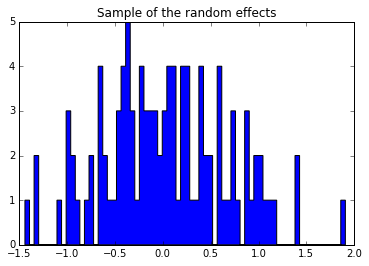

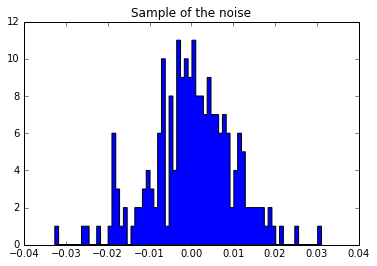

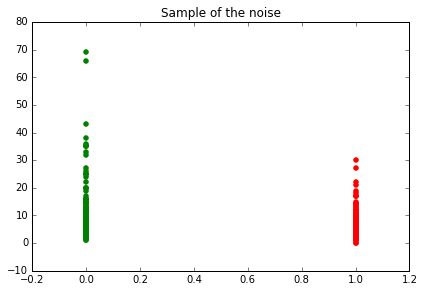

In [73]:
#use 256 from rfdata as the predictor
X = np.array(rfdata.hap1[256] + rfdata.hap2[256])
X1 = np.array(rfdata.hap1[256])
X2 = np.array(rfdata.hap2[256])

#To simulate effect sizes, I will draw from Uniform(.1,.7) and then take the log
#x = np.random.binomial(1,.4, n_count_data)
#X = x*1

#beta
beta_actual =np.log(np.random.beta(25, 12))
sigma_u_actual = 1 #1
sigma_e_actual = .01
beta_0_actual = np.log(10)

y = simulateRespons(X, beta_0_actual, beta_actual, sigma_u_actual, sigma_e_actual, kgeno, n_count_data, True)

y1 = y[:106]
y2 = y[106:]

index = rfdata.group
columns = ['groups','counts', 'haplotype']
df4 = pd.DataFrame(
    {'groups' : index,
     'counts': y,
     'haplotype': X}, index=range(len(index)), columns=columns)
df4.to_csv('useforR.csv')
#rdf = com.convert_to_r_dataframe(df4)
#formula = 'counts ~ haplotype + (1|groups)'
#Mglmm1 = com.glmer(formula, family=poisson(link="log"),data=rdf)
#summary(Mglmm1)

# Verify MCMC
We will apply a Poisson generalized linear model with random effects to data simulated from real phased haplotyes in the GTEx dataset across a single transcript

The model is given by:
- y ~ Pois($\mu$)
- log($\mu$) = $\beta_0$ + x$\beta$ + u + e

where $\beta_0$ is the intercept term, $\beta$ is the effect size, u is the random effect, and e is the error

## Working pymc3 model

In [123]:
%pylab --no-import-all inline

from pymc3 import *
import theano.tensor as tt
from numpy import random, sum as nsum, ones, concatenate, newaxis, dot, arange
import numpy as np

random.seed(1)

n_groups = n_count_data/2
no_pergroup = 2
n_observed = no_pergroup * n_groups
n_group_predictors = G.shape[1]
n_predictors = 1

group = concatenate([range(n_groups) for i in range(no_pergroup)])
#group = concatenate([[i] * no_pergroup for i in range(n_groups)])
group_predictors = G  # random.normal(size = (n_groups, n_group_predictors))
predictors = X
G = np.array(G)

model = Model()
with model:

    # m_g ~ N(0, .1)
    tau_u = pm.Gamma("tau_u", 1.e-3, 1.e-3)
    sigma_u = tau_u**-.5
    group_effects = pm.Normal("individual_effects", 0, tau_u, shape=n_groups)
    random = tt.dot(G,group_effects)

    g = tt.constant(group)
    #Global priors
    tau_e = pm.Gamma("sigma_e", 1.e-3, 1.e-3)
    eps = pm.Normal('error', mu=0, sd=1/tau_e,shape=n_observed)
    intercept = pm.Flat('intercept')
    beta = pm.Normal('effect_size', mu=0, sd=100)
    
    theta = tt.exp(intercept + beta*X + eps + random[g])#  )# )
    y_est = pm.Poisson('y_est', mu=theta, observed=y)
    

    start = find_MAP()
    #h = find_hessian(start)


    step = Metropolis()
    #step = Slice()
    #step = NUTS()
    trace = pm.sample(50000, step, start=start, progressbar=True)

Populating the interactive namespace from numpy and matplotlib
 [-----------------100%-----------------] 50000 of 50000 complete in 21.1 sec

-0.431518674693
0.5
0.01
2.30258509299

tau_u_log:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -3.188           4.038            0.403            [-6.738, 3.653]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -6.696         -6.333         -5.747         1.448          3.715


individual_effects:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.263            0.335            0.012            [-0.382, 0.955]
  -3.569           6.853            0.668            [-18.385, 7.625]
  1.003            0.685            0.048            [-0.046, 2.329]
  -0.750           1.317            0.086            [-3.674, 1.606]
  -6.648           5.352            0.517            [-16.401, 0.43

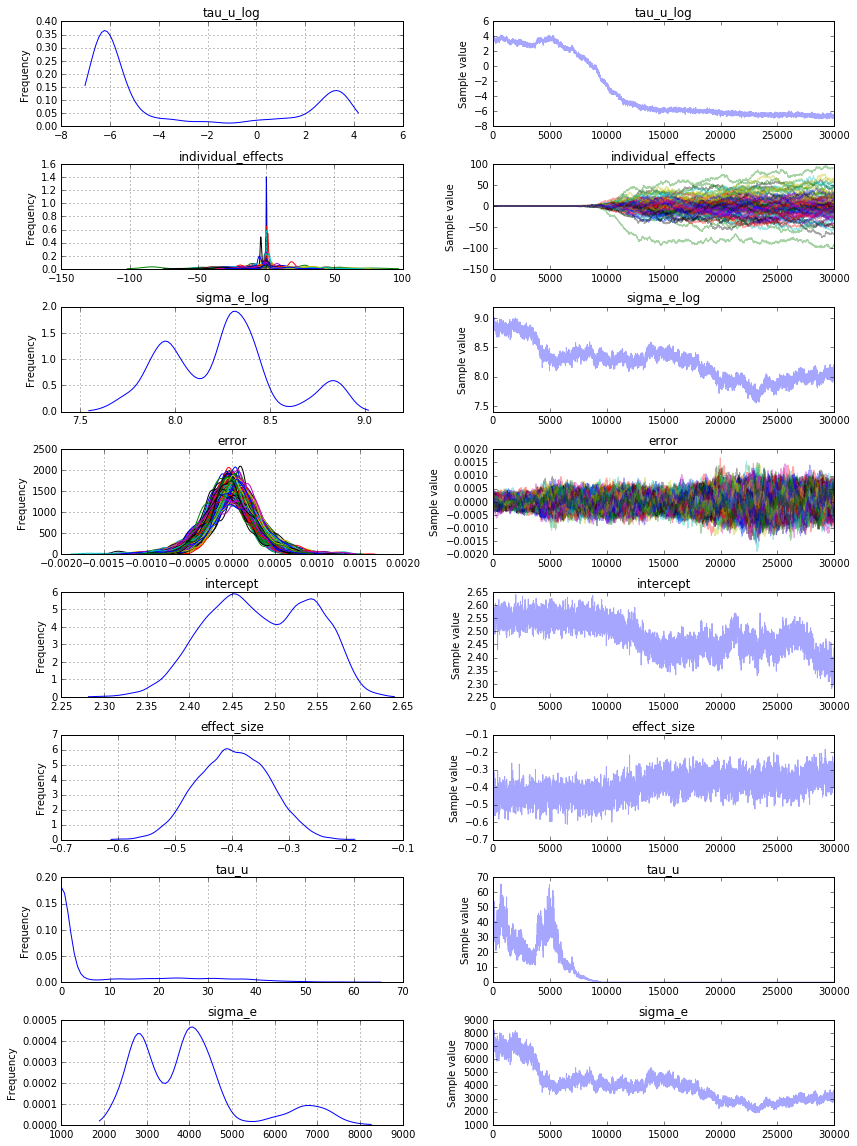

In [124]:
pm.traceplot(trace[20000:])
print beta_actual 
print sigma_u_actual 
print sigma_e_actual 
print beta_0_actual
pm.summary(trace[20000:]);

In [125]:
import seaborn.apionly as sns
print beta_actual 
print sigma_u_actual 
print sigma_e_actual 
print beta_0_actual
#_ = pm.traceplot(trace,vars=['effect_size', 'tau_u', 'sigma_e','intercept','group_effects'])
#_ = sns.pairplot(pm.trace_to_dataframe(trace[20000:]),vars=['effect_size', 'tau_u', 'sigma_e','intercept'], plot_kws={'alpha':.5})

-0.431518674693
0.5
0.01
2.30258509299


In [ ]:
_ = plt.figure(figsize=(5, 6))
_ = pm.forestplot(trace[20000:], vars=['random'], ylabels=group)

## Try pymc3

here
here
 [                  0%                  ] 1132 of 200000 complete in 195.5 sec

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x286f73d90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x2a69902d0>]], dtype=object)

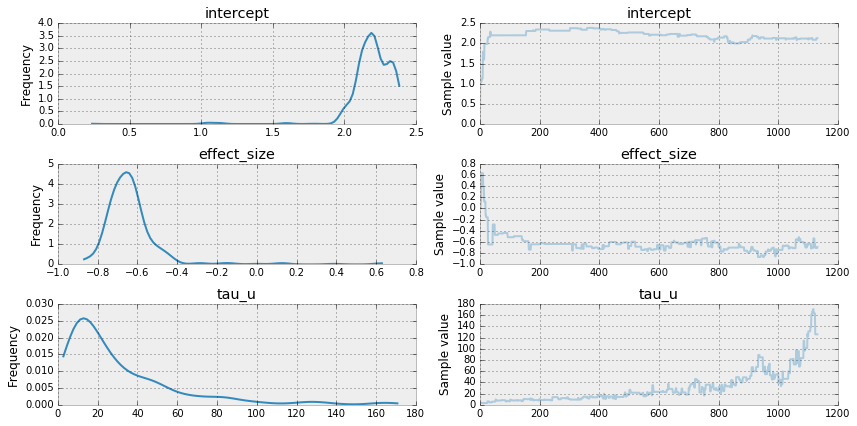

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy
import seaborn.apionly as sns
import scipy.stats as stats
import statsmodels.api as sm
import theano.tensor as tt

from sklearn import preprocessing

%matplotlib inline
plt.style.use('bmh')
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', 
          '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']
#Convert categorical variables to integer
#group = np.array(concatenate([range(n_groups) for i in range(no_pergroup)]))
#le = preprocessing.LabelEncoder()
#participants_idx = le.fit_transform(group)
n_groups = n_count_data/2
no_pergroup = 2
n_observed = no_pergroup * n_groups
n_group_predictors = 1
n_predictors = 1
G = np.array(G)

beta_names = [str(i) for i in range(n_groups)] 
def regress(regression="ridge", beta_names=beta_names, nu=5):
    with pm.Model() as model:
        #
        # Priors
        #
        if regression == "ols":
            randoms = [pm.Uniform(beta, -10, 10) for beta in beta_names] # >10 is really slow...
        elif regression == "ridge":
            tau_u = pm.Gamma("tau_u", 1.e-3, 1.e-3)
            sigma_u = tau_u**-.5
            random = [pm.Normal(beta, mu=0, tau=tau_u) for beta in beta_names]
            randoms = []
            for i in range(n_groups):
                randoms.append(tt.dot(G[i,:],random))
        elif regression == "lasso":
            randoms = [pm.Laplace(beta, mu=0, b=1.0) for beta in beta_names]
        else:
            raise ValueError, "No regression of type {}".format(regression)

        # prior on Normal/T error variance. Gamma(1,1) has mean=1, variance=1
        # HalfCauchy is better...
        tau = pm.HalfCauchy('tau', 1, testval=1.0)
        beta = pm.Normal('effect_size', mu=0, sd=100)
        intercept = pm.Flat('intercept')
        tau_e = pm.Gamma("tau_e", 1.e-3, 1.e-3)
        eps1 = pm.Normal('error1', mu=0,sd=tau_e,shape=n_count_data/2)
        eps2 = pm.Normal('error2', mu=0,sd=tau_e,shape=n_count_data/2)
        #
        # Likelihood
        #
        # mu ~ beta0 + beta1 * x1 + beta2 * x2 + beta3 * x3
        mu1 = tt.exp(intercept + beta*X1 + randoms + eps1)#  )# )
        y1_est = pm.Poisson('y_est', mu=mu1, observed=y1)
        mu2 = tt.exp(intercept + beta*X2 + randoms + eps2)#  )# )
        y2_est = pm.Poisson('y_est', mu=mu2, observed=y2)
    
    with model:
        #start = pm.find_MAP()
        #step = pm.Metropolis()
        #trace = pm.sample(200000, step, start=start, progressbar=True)
        print "here"
        #start = pm.find_MAP()
        #print(map_estimate)
        print "here"
        trace = pm.sample(20000, pm.Metropolis(), progressbar=True)
    return trace


trace = regress(regression="ridge",beta_names=beta_names)
pm.traceplot(trace,['intercept', 'effect_size', 'tau_u'])

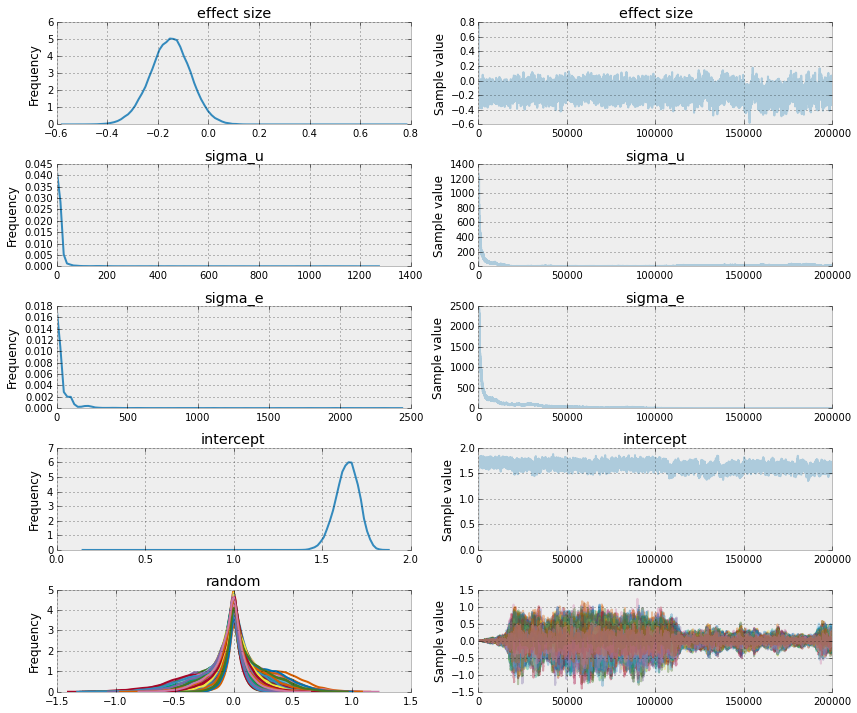

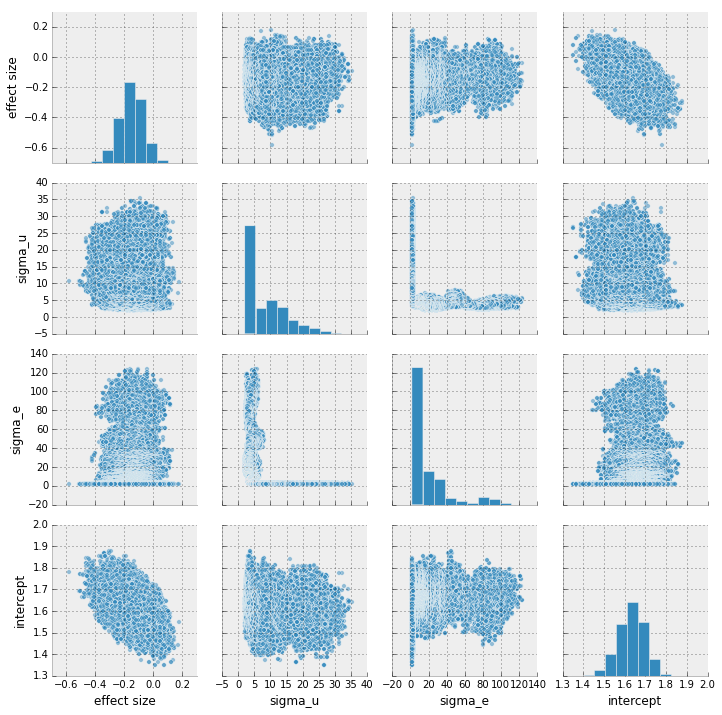

In [58]:
import seaborn.apionly as sns
print beta_actual 
print 1/sigma_u_actual 
print 1/sigma_e_actual 
print beta_0_actual
_ = pm.traceplot(trace,vars=['effect size', 'sigma_u', 'sigma_e','intercept','random'])
_ = sns.pairplot(pm.trace_to_dataframe(trace[20000:]),vars=['effect size', 'sigma_u', 'sigma_e','intercept'], plot_kws={'alpha':.5})

TypeError: object of type 'numpy.int64' has no len()

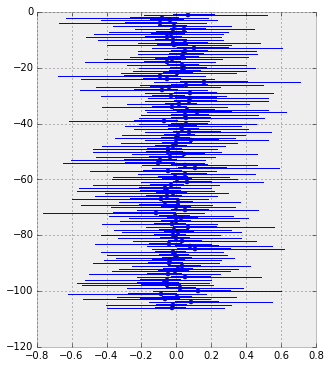

In [ ]:

n_groups = n_count_data/2
no_pergroup = 2
n_observed = no_pergroup * n_groups
n_group_predictors = 1
n_predictors = 1

group = np.array(concatenate([range(n_groups) for i in range(no_pergroup)]))

model = Model()
with model:
    tau_u = pm.Gamma("random", .1, .1)
    # u ~ N(0, 1/tau_u)
    u = pm.Normal("group_effects", 0, 1/tau_u, shape=(1, n_group_predictors))

    tau_e = pm.Gamma("error", .1, .1)
    # sigma_e ~ N(0, 1/tau_e)
    e = pm.Normal("eps", 0, 1/tau_e, shape=(1, n_observed))

    beta_0 = pm.Uniform('intercept', lower=-100, upper=100)
    beta = pm.Normal('effect',mu=0,sd=100**2)
    g = T.constant(group)

    # log(theta) ~ N(beta_o + xbeta + GGu + e, sg)
    effects = Normal("theta", beta_0 + X[g]*beta + GG*u[g] + e,shape=(n_groups, n_predictors))

    # y ~ Pois(m[g] * p, s)
    yd = pm.Poisson('y', np.exp(effects), observed=y)

    #start = find_MAP()
    #h = find_hessian(start)
    

    #step = Metropolis()
    #step = Slice()
    step = NUTS()

with pm.Model() as hierarchical_model:
    # Hyperpriors for group nodes
    sigma_e = pm.InverseGamma('sigma_e', lower=0, upper=100)
    sigma_u = pm.InverseGamma('sigma_u', lower=0, upper=100)
    
    # Intercept for each county, distributed around group mean mu_a
    # Above we just set mu and sd to a fixed value while here we
    # plug in a common group distribution for all a and b (which are
    # vectors of length n_counties).
    u = pm.Normal('u', 0, sd=sigma_u, shape=n_count_data)
    # Intercept for each county, distributed around group mean mu_a
    eps = pm.Normal('eps', 0, sd=sigma_e, shape=n_count_data)
        
    # Model prediction of radon level
    # a[county_idx] translates to a[0, 0, 0, 1, 1, ...],
    # we thus link multiple household measures of a county
    # to its coefficients.
    theta = N*np.exp(beta_0 + X[df4.groups]*beta + u[df4.groups]*GG + e)
    
    # Data likelihood
    likelihood = pm.Poisson('likelihood', theta=theta, observed=y)

indiv_traces = {}


with pm.Model() as model:
    #Model the random terms as normals where the variance priors are IVG
    tau_e = pm.Gamma('tau_e', .1, .1)
    tau_u = pm.Gamma('tau_u', .1, .1)
    u = pm.Normal("u", 1/tau_u, size=n_count_data)
    e = pm.Normal('e',1/tau_e,size=n_count_data)

    #Intercept term is normal
    beta_0 = pm.Uniform('beta_0', lower=-10, upper=10) 

    #The effect size prior will vary
    b1 = 0
    b2 = 1
    beta = pm.Laplace("beta", b1, b2)

    #Need to assign the observations to a distribution for use in pymc
    N = 1
    hap = pm.Normal('x', 0, 1, value=X, observed=True)
    @pm.deterministic
    def theta(beta=beta, beta_0=beta_0, u=u, e=e, X=hap, N=N, GG=GG): 
        return N*np.exp(beta_0 + X*beta + u*GG + e)
    likelihood = pm.Poisson('likelihood', theta=theta, observed=y)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(200000, step, start=start, progressbar=True)
    _ = pm.traceplot(trace, vars=['mu'], lines={'mu': freq_results['x']})

## Test model with G and groups

In [24]:
#Model the random terms as normals where the variance priors are IVG
tau_e = pm.Gamma('tau_e', .1, .1, value=1)
tau_u = pm.Gamma('tau_u', .1, .1,value=1)
u = pm.Normal("u", 1/tau_u, size=n_count_data,value=np.zeros(n_count_data))
e = pm.Normal('e',1/tau_e,size=n_count_data,value=np.zeros(n_count_data))

#Intercept term is normal
beta_0 = pm.Uniform('beta_0', lower=-10, upper=10, value=0) 

#The effect size prior will vary
b1 = 0
b2 = 1
beta = pm.Laplace("beta", b1, b2, value=beta_actual)

#Need to assign the observations to a distribution for use in pymc
N = 1
hap = pm.Normal('x', 0, 1, value=X, observed=True)

#This term models the poisson parameter
@pm.deterministic
def theta(beta=beta, beta_0=beta_0, u=u, e=e, X=hap, N=N, GG=GG): 
    return N*np.exp(beta_0 + X*beta + u*GG + e)

#Model the readcounts as poisson
y_hat = pm.Poisson('y', mu=theta, value=y,observed=True)

#Create the model
model = pm.Model([sigma_u,sigma_e,beta,beta_0,hap,u,e,y_hat,G])

print beta_0_actual
print sigma_u_actual
print sigma_e_actual
print beta_actual

# a visual summary of the model (super ugly)
#Graph the model
graph = pm.graph.graph(model)
IPython.display.SVG(data=graph.create_svg())

ValueError: No value given for parent tau

In [249]:
# prepare for MCMC
#M = pm.MAP(model)
#M.fit()
#mcmc = pm.MCMC(M.variables)
mcmc = pm.MCMC(model)
mcmc.use_step_method(pm.AdaptiveMetropolis, M.beta_0, M.beta)
mcmc.sample(70000, 40000, 10)
pm.Matplot.plot(mcmc)
mcmc.variables
#Summary = mcmc.stats() 
#print Summary
 mcmc.step_method_dict[model.beta]

LinAlgError: 0-dimensional array given. Array must be at least two-dimensional

## Estimate $\beta_0$

In [68]:
#Model the random terms as normals where the variance priors are IVG
sigma_u = pm.Gamma('sigma_u', .1, .1, value=sigma_u_actual,observed=True)
@pm.deterministic(plot=False)
def D(sigma_u = sigma_u, KK=KK):
    return sigma_u*KK
u = pm.MvNormal("u", np.zeros(n_count_data), D)
sigma_e = pm.Gamma('\sigma_e', .1, .1, value=sigma_e_actual,observed=True)
e = pm.Normal('e',0,sigma_e,size=n_count_data)

#Intercept term is normal
beta_0 = pm.Uniform('beta_0', lower=-10, upper=10, value=0) 

#The effect size prior will vary
b1 = 0
b2 = 1
beta = pm.Laplace("beta", b1, b2, value=beta_actual,observed=True)

#Need to assign the observations to a distribution for use in pymc
N = 1
hap = pm.Normal('x', 0, 1, value=X, observed=True)

#This term models the poisson parameter
@pm.deterministic
def theta(beta=beta, beta_0=beta_0, u=u, e=e, X=hap, N=N): 
    return N*np.exp(beta_0 + X*beta + u + e)

#Model the readcounts as poisson
y_hat = pm.Poisson('y', mu=theta, value=y,observed=True)

#Create the model
model = pm.Model([sigma_u,sigma_e,beta,beta_0,hap,u,e,y_hat,D])

print beta_0_actual

# a visual summary of the model (super ugly)
#Graph the model
graph = pm.graph.graph(model)
IPython.display.SVG(data=graph.create_svg())

NameError: name 'sigma_u_actual' is not defined

## Fit the model with MCMC
No burn in and no thinning to examine model

 [-----------------100%-----------------] 50000 of 50000 complete in 22.9 secPlotting beta_0


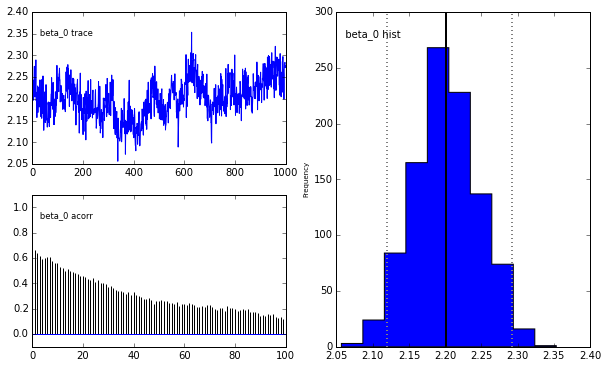

In [123]:
# prepare for MCMC
mcmc = pm.MCMC(model)
#mcmc.use_step_method(pm.AdaptiveMetropolis, beta_0)
mcmc.sample(50000, 40000, 10)
pm.Matplot.plot(mcmc)
#Summary = mcmc.stats() 
#print Summary 

## Estimate $\sigma_u$

0.5


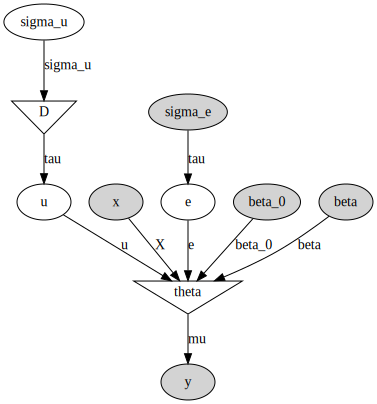

In [140]:
#Model the random terms as normals where the variance priors are IVG
sigma_u = pm.Gamma('sigma_u', .01, .01, value=1)
@pm.deterministic(plot=False)
def D(sigma_u = sigma_u, KK=KK):
    return sigma_u*KK
u = pm.MvNormal("u", np.zeros(n_count_data), D)
sigma_e = pm.Gamma('\sigma_e', .1, .1, value=sigma_e_actual,observed=True)
e = pm.Normal('e',0,sigma_e,size=n_count_data)

#Intercept term is normal
beta_0 = pm.Uniform('beta_0', lower=-10, upper=10,value=beta_0_actual,observed=True) 

#The effect size prior will vary
b1 = 0
b2 = 1
beta = pm.Laplace("beta", b1, b2, value=beta_actual,observed=True)

#Need to assign the observations to a distribution for use in pymc
N = 1
hap = pm.Normal('x', 0, 1, value=X, observed=True)

#This term models the poisson parameter
@pm.deterministic
def theta(beta=beta, beta_0=beta_0, u=u, e=e, X=hap, N=N): 
    return N*np.exp(beta_0 + X*beta + u + e)

#Model the readcounts as poisson
y_hat = pm.Poisson('y', mu=theta, value=y,observed=True)

#Create the model
model = pm.Model([sigma_u,sigma_e,beta,beta_0,hap,u,e,y_hat,D])

print sigma_u_actual
# a visual summary of the model (super ugly)
#Graph the model
graph = pm.graph.graph(model)
IPython.display.SVG(data=graph.create_svg())

 [-----------------100%-----------------] 50000 of 50000 complete in 33.5 secPlotting sigma_u


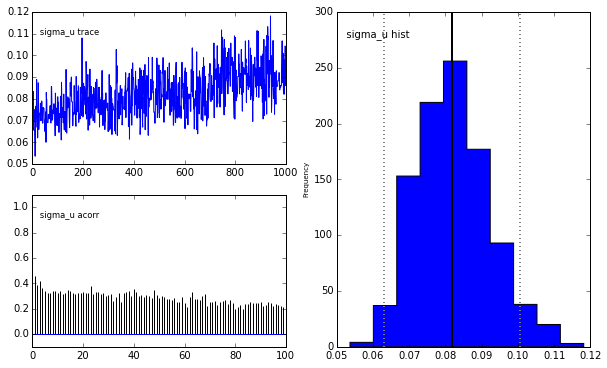

In [141]:
# prepare for MCMC
mcmc = pm.MCMC(model)
mcmc.use_step_method(pm.AdaptiveMetropolis, sigma_u)
mcmc.sample(50000, 40000, 10)
pm.Matplot.plot(mcmc)
#Summary = mcmc.stats() 
#print Summary 

## Estimating $\sigma_e$

0.01


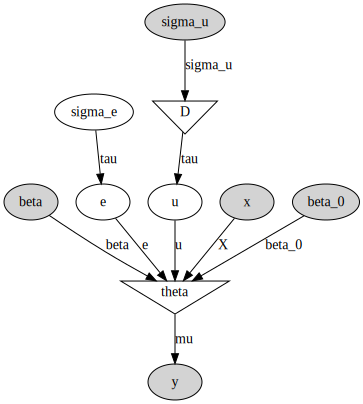

In [127]:
#Model the random terms as normals where the variance priors are IVG
sigma_u = pm.Gamma('sigma_u', .1, .1,value=sigma_u_actual,observed=True)
@pm.deterministic(plot=False)
def D(sigma_u = sigma_u, KK=KK):
    return sigma_u*KK
u = pm.MvNormal("u", np.zeros(n_count_data), D)
sigma_e = pm.Gamma('\sigma_e', .1, .1)
e = pm.Normal('e',0,sigma_e,size=n_count_data)

#Intercept term is normal
beta_0 = pm.Uniform('beta_0', lower=-10, upper=10,value=beta_0_actual,observed=True) 

#The effect size prior will vary
b1 = 0
b2 = 1
beta = pm.Laplace("beta", b1, b2, value=beta_actual,observed=True)

#Need to assign the observations to a distribution for use in pymc
N = 1
hap = pm.Normal('x', 0, 1, value=X, observed=True)

#This term models the poisson parameter
@pm.deterministic
def theta(beta=beta, beta_0=beta_0, u=u, e=e, X=hap, N=N): 
    return N*np.exp(beta_0 + X*beta + u + e)

#Model the readcounts as poisson
y_hat = pm.Poisson('y', mu=theta, value=y,observed=True)

#Create the model
model = pm.Model([sigma_u,sigma_e,beta,beta_0,hap,u,e,y_hat,D])

print sigma_e_actual

# a visual summary of the model (super ugly)
#Graph the model
graph = pm.graph.graph(model)
IPython.display.SVG(data=graph.create_svg())

 [-----------------100%-----------------] 50000 of 50000 complete in 27.5 secPlotting \sigma_e


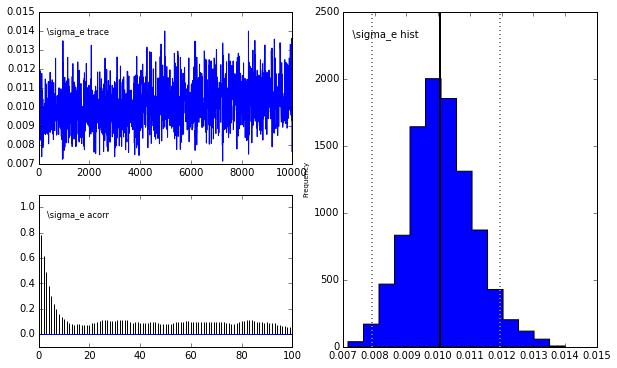

In [128]:
# prepare for MCMC
mcmc = pm.MCMC(model)
mcmc.use_step_method(pm.AdaptiveMetropolis, sigma_e)
mcmc.sample(50000, 40000)
pm.Matplot.plot(mcmc)
#Summary = mcmc.stats() 
#print Summary 

## Reparameterize the random effects 
The variance terms are not being estimated well so I will reparameterize them as $\nu = e + u$

0.01


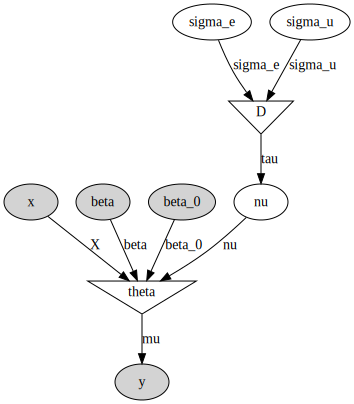

In [129]:
#Model the random terms as normals where the variance priors are IVG
sigma_u = pm.Gamma('sigma_u', .1, .1)
sigma_e = pm.Gamma('\sigma_e', .1, .1)
@pm.deterministic(plot=False)
def D(sigma_u = sigma_u, sigma_e=sigma_e, KK=KK):
    return sigma_u*KK + sigma_e*np.diag(np.ones(n_count_data))
nu = pm.MvNormal("nu", np.zeros(n_count_data), D)

#Intercept term is normal
beta_0 = pm.Uniform('beta_0', lower=-10, upper=10,value=beta_0_actual,observed=True) 

#The effect size prior will vary
b1 = 0
b2 = 1
beta = pm.Laplace("beta", b1, b2, value=beta_actual,observed=True)

#Need to assign the observations to a distribution for use in pymc
N = 1
hap = pm.Normal('x', 0, 1, value=X, observed=True)

#This term models the poisson parameter
@pm.deterministic
def theta(beta=beta, beta_0=beta_0, nu=nu, X=hap, N=N): 
    return N*np.exp(beta_0 + X*beta + nu)

#Model the readcounts as poisson
y_hat = pm.Poisson('y', mu=theta, value=y,observed=True)

#Create the model
model = pm.Model([sigma_u,sigma_e,beta,beta_0,hap,nu,y_hat,D])

print sigma_e_actual

# a visual summary of the model (super ugly)
#Graph the model
graph = pm.graph.graph(model)
IPython.display.SVG(data=graph.create_svg())

 [-----------------100%-----------------] 50000 of 50000 complete in 55.0 secPlotting sigma_u
Plotting \sigma_e


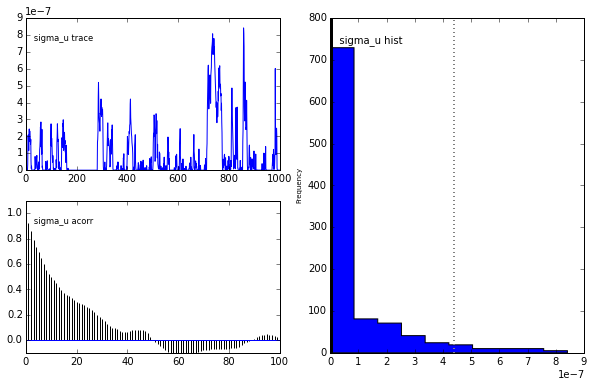

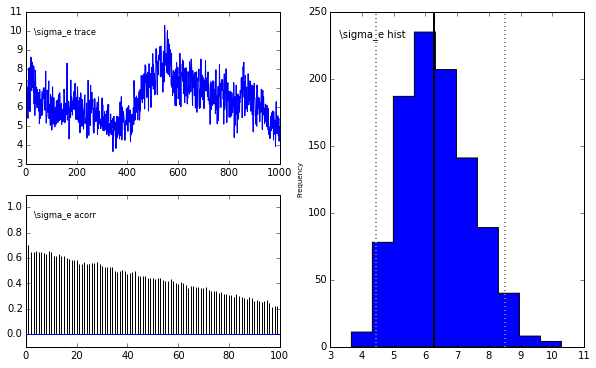

In [130]:
# prepare for MCMC
mcmc = pm.MCMC(model)
#mcmc.use_step_method(pm.AdaptiveMetropolis, sigma_e)
mcmc.sample(50000,40000,10)
pm.Matplot.plot(mcmc)
#Summary = mcmc.stats() 
#print Summary 

## Estimate all of the parameters 

0.01
0.5
2.30258509299
-0.289029565935


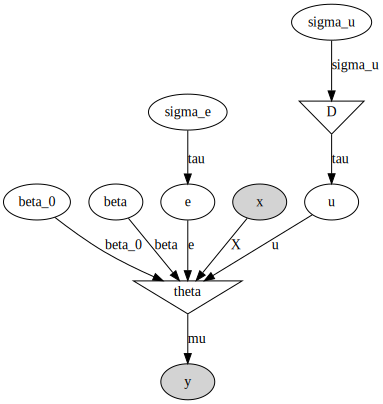

In [131]:
#Model the random terms as normals where the variance priors are IVG
sigma_u = pm.Gamma('sigma_u', .1, .1)
@pm.deterministic(plot=False)
def D(sigma_u = sigma_u, KK=KK):
    return sigma_u*KK
u = pm.MvNormal("u", np.zeros(n_count_data), D)
sigma_e = pm.Gamma('\sigma_e', .1, .1)
e = pm.Normal('e',0,sigma_e,size=n_count_data)

#Intercept term is normal
beta_0 = pm.Uniform('beta_0', lower=-10, upper=10) 

#The effect size prior will vary
b1 = 0
b2 = 1
beta = pm.Laplace("beta", b1, b2)

#Need to assign the observations to a distribution for use in pymc
N = 1
hap = pm.Normal('x', 0, 1, value=X, observed=True)

#This term models the poisson parameter
@pm.deterministic
def theta(beta=beta, beta_0=beta_0, u=u, e=e, X=hap, N=N): 
    return N*np.exp(beta_0 + X*beta + u + e)

#Model the readcounts as poisson
y_hat = pm.Poisson('y', mu=theta, value=y,observed=True)

#Create the model
model = pm.Model([sigma_u,sigma_e,beta,beta_0,hap,u,e,y_hat,D])

print sigma_e_actual
print sigma_u_actual
print beta_0_actual
print beta_actual

# a visual summary of the model (super ugly)
#Graph the model
graph = pm.graph.graph(model)
IPython.display.SVG(data=graph.create_svg())

 [-----------------100%-----------------] 50000 of 50000 complete in 46.1 secPlotting beta
Plotting beta_0
Plotting sigma_u
Plotting \sigma_e


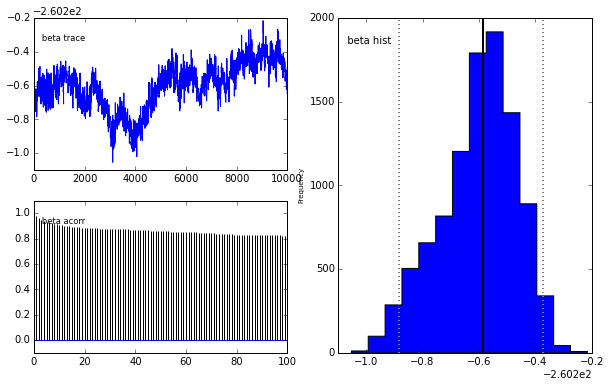

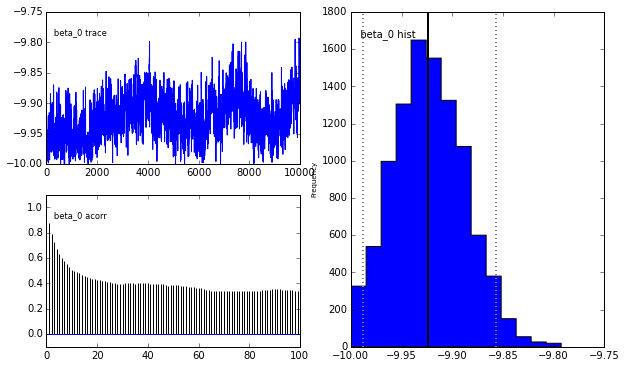

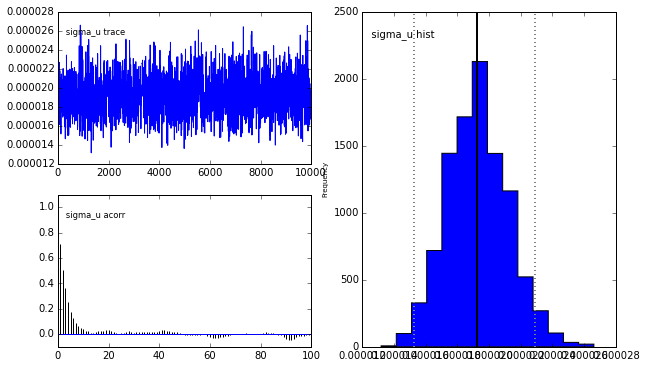

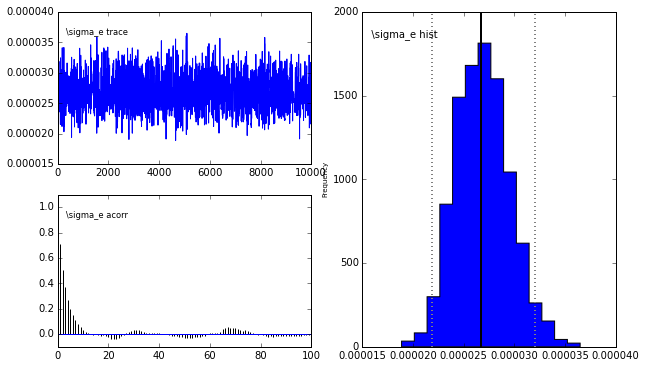

In [133]:
# prepare for MCMC
#M = pm.MAP(model)
#M.fit()
mcmc = pm.MCMC(M.variables)
#mcmc.use_step_method(pm.AdaptiveMetropolis, sigma_e)
mcmc.sample(50000,40000)
pm.Matplot.plot(mcmc)
#Summary = mcmc.stats() 
#print Summary 

In [122]:
%%latex
\begin{equation}
p((\beta, \beta_0, \sigma_u, \sigma_e | y)  \propto 
 \int \int \left[ \left\{ \prod_{i=1}^{2n} exp(-N_ie^{\beta_0 + x_i\beta + u_i + e_i}e^{y_i(\beta_0 + x_i\beta + u_i + e_i)}\right\} 
 \frac{1}{|V|^{1/2}} exp(-\frac{1}{2}(e + u)'V^{-1}(e + u)) \right] \; de \; du \; p(\beta)p(\sigma_u)p(\sigma_e)I_{\beta_0 \in R}
\end{equation}
where $V = \sigma_eI + \sigma_u*KK$


<IPython.core.display.Latex object>

# Try rpy2 and use R's glmm package

In [186]:
from numpy import *
import scipy as sp
import pandas as pd
from rpy2.robjects.packages import importr
import rpy2.robjects as ro
import rpy2.robjects.packages as rpackages
import pandas.rpy.common as com
packnames = ("lme4","MCMCglmm","blme",
               "pbkrtest","coda","aods3","bbmle","ggplot2",
               "reshape2","plyr","numDeriv","Hmisc",
               "plotMCMC","gridExtra","R2admb")
if all(rpackages.isinstalled(x) for x in packnames):
    have_tutorial_packages = True
else:
    have_tutorial_packages = False
if not have_tutorial_packages:
    # import R's utility package
    utils = rpackages.importr('utils')
    # select a mirror for R packages
    utils.chooseCRANmirror(ind=1) # select the first mirror in the list
    # R vector of strings
    from rpy2.robjects.vectors import StrVector
    # file
    packnames_to_install = [x for x in packnames if not rpackages.isinstalled(x)]
    if len(packnames_to_install) > 0:
        utils.install_packages(StrVector(packnames_to_install))
l = importr('glmer')

RRuntimeError: Error in loadNamespace(name) : there is no package called ‘glmer’


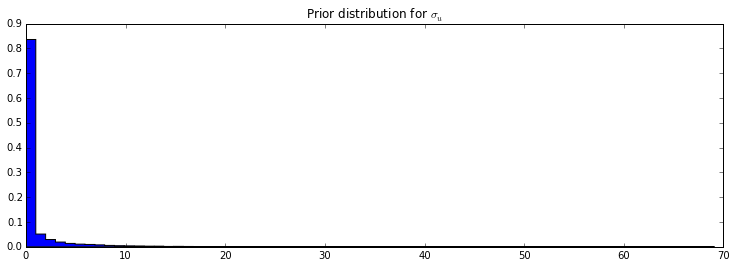

In [69]:
%matplotlib inline
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt
figsize(12.5, 4)

samples = [sigma_u.random() for i in range(20000)]
plt.hist(samples, bins=70, normed=True, histtype="stepfilled")
plt.title("Prior distribution for $\sigma_u$")

In [ ]:
k = getrelatedness
N = totcounts


u = pm.multinomial_like("u",np.zeros(n_count_data), sigma_u*k)
e = pm.multinomial_like("e",np.zeros(n_count_data), sigma_e*diag(ones(n_count_data)))
tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data)

@pm.deterministic
def loglink_(u=u, e=e, beta=beta, beta_0=beta_0, x=x):
    out = np.zeros(n_count_data)
    out[:] = np.log(beta_0 + x*beta + u + e)
    out = log(N) + out[:]
    return out

observation = pm.Poisson("obs", lambda_, value=count_data, observed=True)

model = pm.Model([observation, lambda_1, lambda_2, tau])

In [ ]:

#beta is normal, cachy, laplace, and ....
#betas = pm.Uniform("betas", 0, 1, size=N)